In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
from SWMat.SWMat import SWMat

sns.set_palette('muted')

In [2]:
fpath = '/mnt/c/notebooks/ds-101/auxiliary/1-statistics/task-1/data.tsv'
df = pd.read_csv(fpath, sep='\t')
df=df.rename(columns = {'Top 10%':'Top_10%'})

Let's take a first look at the data.

In [3]:
df.head(3)

,School,School_Type,SAT,Acceptance,$/Student,Top_10%,%PhD,Grad%
0,Amherst,Lib Arts,1315,22,26636,85,81,93
1,Swarthmore,Lib Arts,1310,24,27487,78,93,88
2,Williams,Lib Arts,1336,28,23772,86,90,93


In [4]:
df.tail(3)

,School,School_Type,SAT,Acceptance,$/Student,Top_10%,%PhD,Grad%
47,Northwestern,Univ,1230,47,28851,77,79,82
48,Washington U (MO),Univ,1225,54,39883,71,98,76
49,U of Rochester,Univ,1155,56,38597,52,96,73


In [5]:
school_types = df['School_Type'].unique()
print(f"School types: {', '.join(school_types)}")

School types: Lib Arts, Univ


We can see that our dataset is described by six numeric variables: "SAT", "Acceptance", "$/Student", "Top_10\%", "\%PhD", "Grad\%". Other two are categorical, "School" contains unique school names, while "School_Type" describes a given school as either a liberal arts college ("Lib Arts") or a research university ('Univ').

Let's check if our data has any missing values.

In [6]:
df.isna().sum()

School         0
School_Type    0
SAT            0
Acceptance     0
$/Student      0
Top_10%        0
%PhD           0
Grad%          0
dtype: int64

Apparently it doesn't, so that saves us from hassle of dealing with that.

Let's check if we notice anything interesting in descriptive statistics.

In [7]:
df.describe(include='all')

,School,School_Type,SAT,Acceptance,$/Student,Top_10%,%PhD,Grad%
count,50,50,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
unique,50,2,NaN,NaN,NaN,NaN,NaN,NaN
top,Hamilton,Univ,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,25,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1263.960000,37.840000,30247.200000,74.440000,90.560000,83.480000
std,NaN,NaN,62.329591,13.363612,15266.172682,13.515162,8.258972,7.557237
min,NaN,NaN,1109.000000,17.000000,17520.000000,47.000000,58.000000,61.000000
25%,NaN,NaN,1225.000000,25.750000,20182.250000,65.000000,86.250000,77.250000
50%,NaN,NaN,1264.000000,36.000000,24994.500000,76.500000,93.000000,85.500000
75%,NaN,NaN,1304.500000,47.750000,36803.750000,85.000000,97.750000,89.000000


The first thing that catches an eye is that "$/Student" mean is significantly larger than its median, let's check its distribution and boxplot.

((array([27.,  9.,  6.,  4.,  2.,  1.,  0.,  0.,  0.,  1.]),
  array([ 17520. ,  25994.2,  34468.4,  42942.6,  51416.8,  59891. ,
          68365.2,  76839.4,  85313.6,  93787.8, 102262. ]),
  <a list of 10 Patch objects>),
 [])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


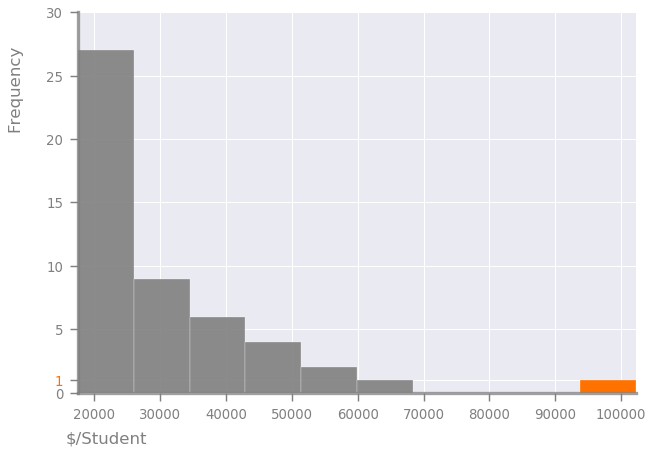

In [8]:
swm = SWMat(plt)
swm.hist(df['$/Student'], bins=10, highlight=9)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


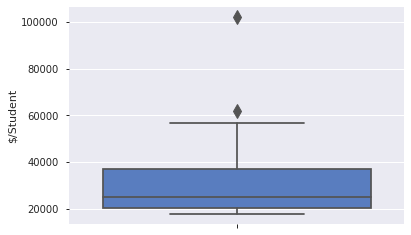

In [9]:
sns.boxplot(df['$/Student'], orient='v', fliersize=10)

Distribution seems to be log-normal and there're some outliers in the right tail.

Let's check variables cross correlation.

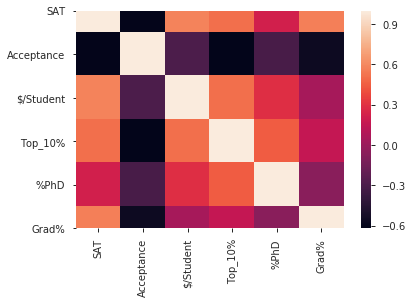

In [10]:
sns.heatmap(df.corr())

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


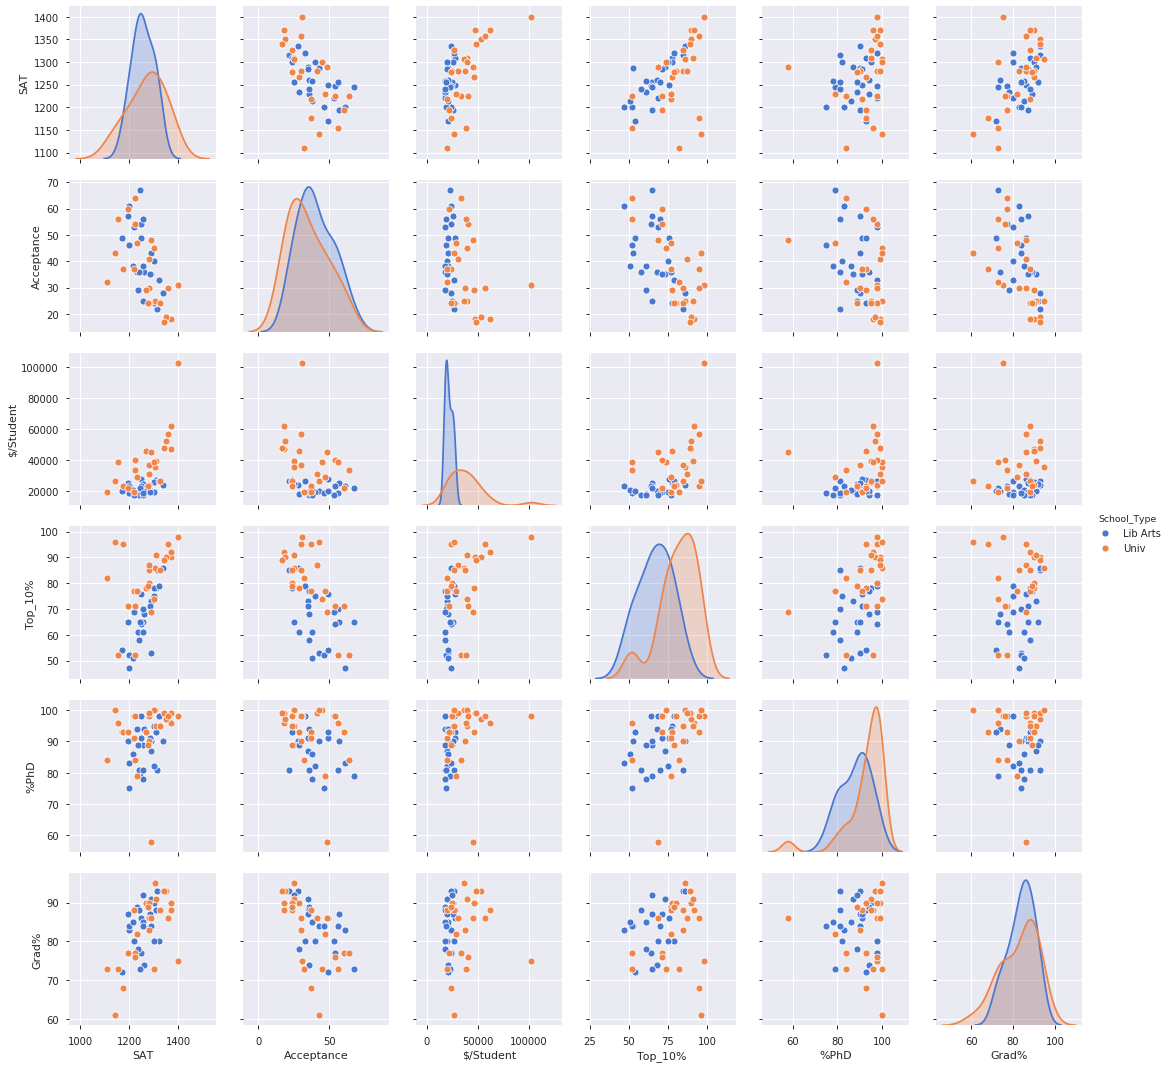

In [11]:
sns.pairplot(df, hue='School_Type')

An interesting observation is that distribution of dollars spent per student of liberal arts is much more concentrated than the same variable distribution for research universities.

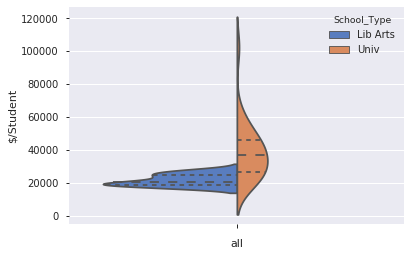

In [12]:
df['all'] = ''
sns.violinplot(x='all', y='$/Student', hue='School_Type', data=df, split=True, inner="quartile")

Heatmap and pair plot don't show significant cross corellation, but let's take a look at pairs that have the highest cross correlation:
- $/Student and SAT (Median combined Math and Verbal SAT score of students) 
- Top_10\% (of h.s. graduating class) and SAT
- Top_10\% and \%PhD
- SAT and Grad\%

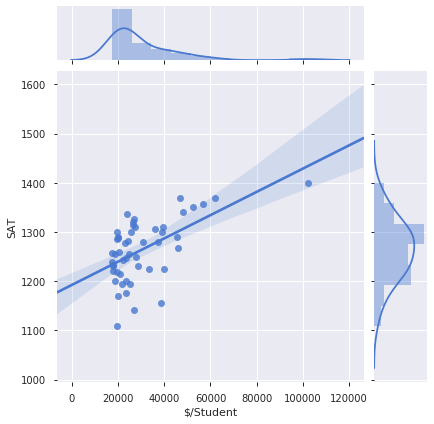

In [13]:
sns.jointplot(x='$/Student', y='SAT', data=df, kind='reg')

These correlations are probably not so difficult to explan, apparently the more money is spent on students the more likely they have higher score (and maybe vice versa), or for example the more students came from their h.s. top 10% the higher school's SAT is. However we can see that correlations are not so high to reject some of these variables.

Let's try pandas profiling to see if we've missed something.

In [14]:
profile = df.profile_report(title='Universities EDA')
profile.to_file(output_file="universities-eda.html")
profile

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Seems like the dataset is quite clean indeed and we didn't get any warnings. Apart from $/Student there may be some outliers in \%PhD and Grad\%.

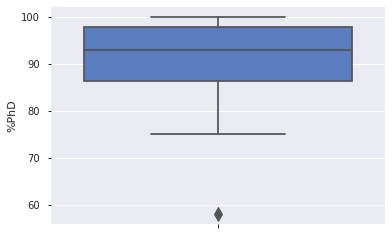

In [15]:
sns.boxplot(df['%PhD'], orient='v', fliersize=10)

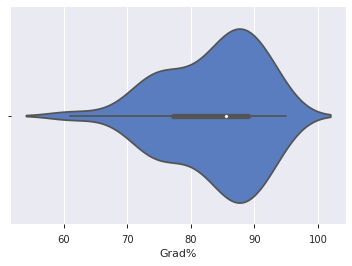

In [16]:
sns.violinplot(df['Grad%'])

\%PhD indeed seems to have an outlier in the left tail and Grad\% has a suspiciously large left whisker. Let's cut off outliers in our data.

In [17]:
numeric_vals = ['$/Student', '%PhD', 'Acceptance', 'Grad%', 'SAT', 'Top_10%']
df_num = df[numeric_vals]

Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

outliers = ((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR)))
print(outliers)

df_out = df_num[~outliers.any(axis=1)]
num_outliers = len(df) - len(df_out)
print(f'{num_outliers} outliers removed')

    $/Student   %PhD  Acceptance  Grad%    SAT  Top_10%
0       False  False       False  False  False    False
1       False  False       False  False  False    False
2       False  False       False  False  False    False
3       False  False       False  False  False    False
4       False  False       False  False  False    False
5       False  False       False  False  False    False
6       False  False       False  False  False    False
7       False  False       False  False  False    False
8       False  False       False  False  False    False
9       False  False       False  False  False    False
10      False  False       False  False  False    False
11      False  False       False  False  False    False
12      False  False       False  False  False    False
13      False  False       False  False  False    False
14      False  False       False  False  False    False
15      False  False       False  False  False    False
16      False  False       False  False  False  

Seems like in the end Grad\% doesn't have outliers.

Let's plot violinplots for $/Student and \%PhD with outliers removed.

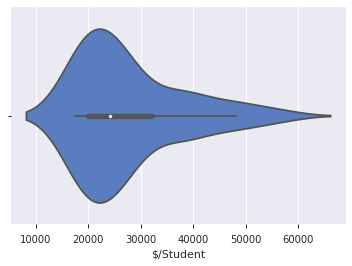

In [18]:
sns.violinplot(df_out['$/Student'])

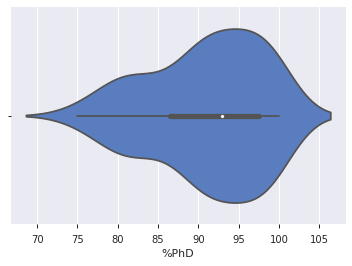

In [19]:
sns.violinplot(df_out['%PhD'])